# Libraries

In [ ]:

import matplotlib.pyplot as plt
import numpy as np
import os as os
import pandas as pd
import seaborn as sns

import random
random.seed(0) # pick your seed

from sklearn.cluster import KMeans
from sklearn.feature_selection import mutual_info_regression
from sklearn.decomposition import PCA
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

# Data

In [ ]:
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
  from google.colab import drive
  drive.mount('/content/gdrive', force_remount=True)
  dir = os.path.join('gdrive', 'My Drive', 'Eurostat', '02 - Data Science for Structured Data')
  os.system('cd "gdrive${dir}" && mkdir -p data')
else:
  dir = "." 

data_dir = os.path.join(dir, 'data')

Mounted at /content/gdrive


In [ ]:
df_iris = pd.read_csv(os.path.join(data_dir, 'iris.csv'),
                      header=None,
                      names=['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class'])
df_iris.sample(3)

,sepal_length,sepal_width,petal_length,petal_width,class
113,5.7,2.5,5.0,2.0,Iris-virginica
32,5.2,4.1,1.5,0.1,Iris-setosa
119,6.0,2.2,5.0,1.5,Iris-virginica


In [ ]:
df_pima = pd.read_csv(os.path.join(data_dir, 'pima.csv'),
                      header=8,
                      names = ['preg', 'gluc', 'pres', 'skin' ,'insu', 'bmi', 'pedi', 'age', 'class'])
df_pima.sample(3)

,preg,gluc,pres,skin,insu,bmi,pedi,age,class
33,6,92,92,0,0,19.9,0.188,28,0
666,4,145,82,18,0,32.5,0.235,70,1
230,4,142,86,0,0,44.0,0.645,22,1


In [ ]:
df_wine = pd.read_csv(os.path.join(data_dir, 'wine.csv'), 
                      sep=';')
df_wine.sample(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1108,8.1,0.78,0.10,3.3,0.090,4.0,13.0,0.99855,3.36,0.49,9.5,5
1169,7.6,0.50,0.29,2.3,0.086,5.0,14.0,0.99502,3.32,0.62,11.5,6
653,9.4,0.33,0.59,2.8,0.079,9.0,30.0,0.99760,3.12,0.54,12.0,6


In [ ]:
df_housing = pd.read_csv(os.path.join(data_dir, 'housing.csv'))
df_housing.sample(3)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
459,6.80117,0.0,18.1,0,0.713,6.081,84.4,2.7175,24,666,20.2,396.90,14.70,20.0
367,13.52220,0.0,18.1,0,0.631,3.863,100.0,1.5106,24,666,20.2,131.42,13.33,23.1
221,0.40771,0.0,6.2,1,0.507,6.164,91.3,3.0480,8,307,17.4,395.24,21.46,21.7


In [ ]:
df_happiness = pd.read_csv(os.path.join(data_dir, 'happiness.csv'))
df_happiness.sample(3)

,isced11,sex,age,geo,time,ACCSAT,COMSAT,FINSAT,GREENSAT,JOBSAT,LIFESAT,LIVENVSAT,MEANLIFE,RELSAT,TIMESAT
684,ED0-2,M,Y65-74,PT,2018,NaN,NaN,5.0,NaN,6.8,6.4,NaN,NaN,8.1,7.3
568,ED0-2,M,Y50-64,CZ,2013,6.7,6.7,4.9,7.4,6.7,5.4,7.2,6.5,7.5,6.8
408,ED0-2,M,Y16-24,RO,2018,NaN,NaN,6.6,NaN,5.8,8.1,NaN,NaN,8.0,7.6


# Feature Engineering
Make your data better suited to the problem at hand!

Goal:
- improve a model's predictive performance
- reduce computational or data needs
- improve interpretability of the results

## Mutual Information

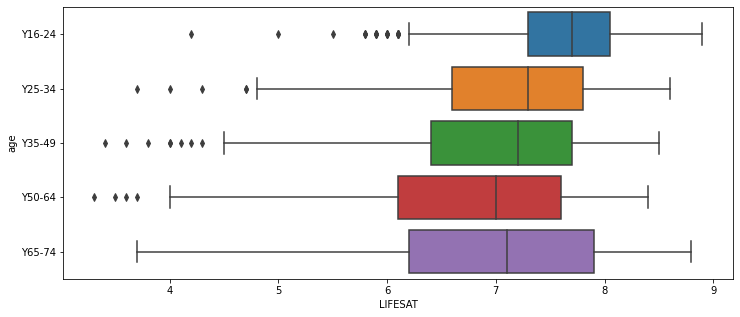

In [ ]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.boxplot(data=df_happiness,
            y='age',
            x='LIFESAT',
            orient='h')

In [ ]:
from sklearn.feature_selection import mutual_info_regression

In [ ]:
def make_mi_scores(X, y, is_discrete_feature):
  mi_scores = mutual_info_regression(X, y, discrete_features=is_discrete_feature)
  mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
  mi_scores = mi_scores.sort_values(ascending=False)
  return mi_scores

In [ ]:
X = df_happiness.copy().drop('LIFESAT', axis=1)
y = df_happiness['LIFESAT']

# Fill-in missing values
X.fillna(0, inplace=True)

# Ordinal-encode discrete features
is_discrete_feature = [X[col].dtype == 'object' for col in X]
X[X.columns[is_discrete_feature]] = OrdinalEncoder().fit_transform(X[X.columns[is_discrete_feature]])
print('Discrete Features: ', X.columns[is_discrete_feature])

# Compute MI
mi_scores = make_mi_scores(X, y, is_discrete_feature)
mi_scores

Discrete Features:  Index(['isced11', 'sex', 'age', 'geo'], dtype='object')


FINSAT       0.818961
geo          0.473803
JOBSAT       0.428320
RELSAT       0.403771
MEANLIFE     0.301168
ACCSAT       0.263564
GREENSAT     0.253854
TIMESAT      0.238932
LIVENVSAT    0.237739
isced11      0.122884
COMSAT       0.118621
age          0.045827
sex          0.002906
time         0.000000
Name: MI Scores, dtype: float64

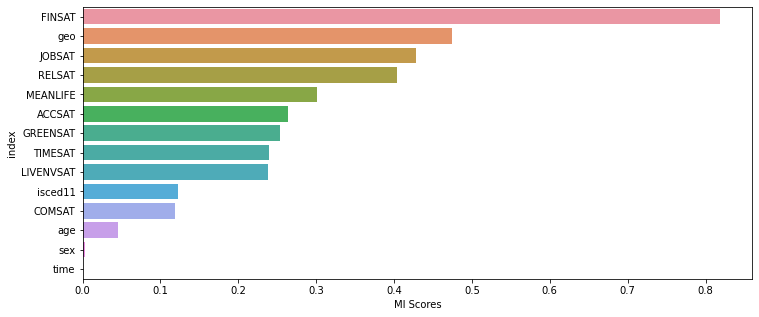

In [ ]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(data=mi_scores.to_frame().reset_index(),
            y='index',
            x='MI Scores',
            orient='h')

In [ ]:
mi_scores.to_frame().reset_index()

,index,MI Scores
0,FINSAT,0.818961
1,geo,0.473803
2,JOBSAT,0.428320
3,RELSAT,0.403771
4,MEANLIFE,0.301168
5,ACCSAT,0.263564
6,GREENSAT,0.253854
7,TIMESAT,0.238932
8,LIVENVSAT,0.237739
9,isced11,0.122884


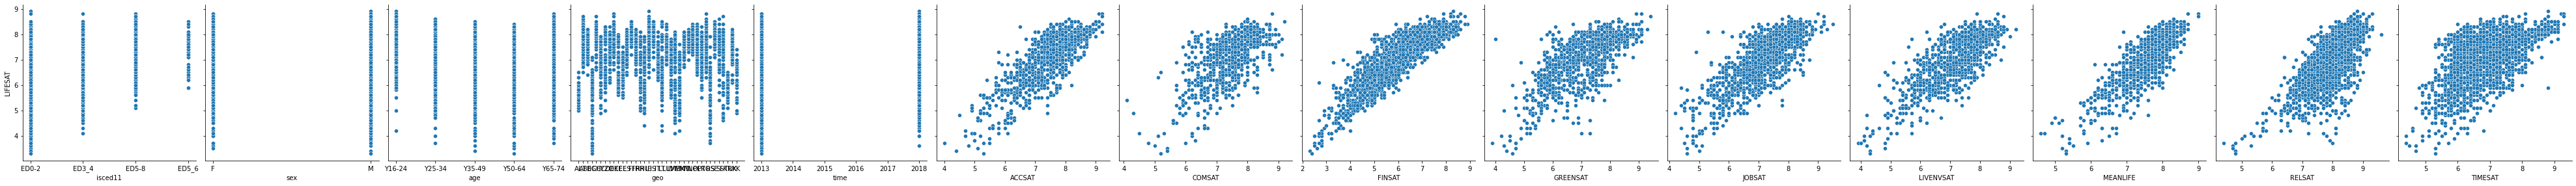

In [ ]:
sns.pairplot(data=df_happiness,
             x_vars=df_happiness.columns.drop('LIFESAT'),
             y_vars=['LIFESAT'],       
             height=4)

## Engineered Features

### Domain Knowledge

In [ ]:
df_wine_domain = df_wine.copy()

df_wine_domain['salts'] = df_wine_domain['chlorides'] + df_wine_domain['sulphates']
df_wine_domain.sample(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,salts
972,10.1,0.38,0.50,2.4,0.104,6.0,13.0,0.99643,3.22,0.65,11.6,7,0.754
808,7.4,0.53,0.12,1.9,0.165,4.0,12.0,0.99702,3.26,0.86,9.2,5,1.025
1560,7.8,0.60,0.26,2.0,0.080,31.0,131.0,0.99622,3.21,0.52,9.9,5,0.600
138,7.8,0.56,0.19,2.1,0.081,15.0,105.0,0.99620,3.33,0.54,9.5,5,0.621
1122,6.3,0.47,0.00,1.4,0.055,27.0,33.0,0.99220,3.45,0.48,12.3,6,0.535


In [ ]:
X = df_wine_domain.drop('quality', axis=1)
y = df_wine_domain['quality']
mi_scores = make_mi_scores(X, y, is_discrete_feature = [False]*len(X.columns))
mi_scores

alcohol                 0.182267
salts                   0.133873
volatile acidity        0.113758
density                 0.090372
sulphates               0.087593
citric acid             0.059449
total sulfur dioxide    0.054644
pH                      0.041393
fixed acidity           0.034593
chlorides               0.032357
free sulfur dioxide     0.017711
residual sugar          0.012814
Name: MI Scores, dtype: float64

### Polynomial Features

Generate a new feature matrix consisting of all polynomial combinations of the features with degree less than or equal to the specified degree. 

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2, include_bias=False)
pd.DataFrame(poly.fit_transform(df_iris.iloc[:,:-1]),
             index=df_iris.index)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,5.1,3.5,1.4,0.2,26.01,17.85,7.14,1.02,12.25,4.90,0.70,1.96,0.28,0.04
1,4.9,3.0,1.4,0.2,24.01,14.70,6.86,0.98,9.00,4.20,0.60,1.96,0.28,0.04
2,4.7,3.2,1.3,0.2,22.09,15.04,6.11,0.94,10.24,4.16,0.64,1.69,0.26,0.04
3,4.6,3.1,1.5,0.2,21.16,14.26,6.90,0.92,9.61,4.65,0.62,2.25,0.30,0.04
4,5.0,3.6,1.4,0.2,25.00,18.00,7.00,1.00,12.96,5.04,0.72,1.96,0.28,0.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,44.89,20.10,34.84,15.41,9.00,15.60,6.90,27.04,11.96,5.29
146,6.3,2.5,5.0,1.9,39.69,15.75,31.50,11.97,6.25,12.50,4.75,25.00,9.50,3.61
147,6.5,3.0,5.2,2.0,42.25,19.50,33.80,13.00,9.00,15.60,6.00,27.04,10.40,4.00
148,6.2,3.4,5.4,2.3,38.44,21.08,33.48,14.26,11.56,18.36,7.82,29.16,12.42,5.29


### Counts
are especially helpful for tree models, since these models don't have a natural way of aggregating information across many features at once.

In [ ]:
df_happiness_counts = df_happiness.copy()
sat_cats = ['ACCSAT', 'COMSAT', 'FINSAT', 'GREENSAT', 'JOBSAT', 'LIVENVSAT', 'MEANLIFE', 'RELSAT', 'TIMESAT']
sat_counts = []
for _, row in df_happiness_counts.iterrows():
  sat_counts.append(np.sum([row[col]<5 for col in sat_cats]))
df_happiness_counts['UNSAT_COUNT'] = sat_counts

In [ ]:
df_happiness_counts.sample(5)

,isced11,sex,age,geo,time,ACCSAT,COMSAT,FINSAT,GREENSAT,JOBSAT,LIFESAT,LIVENVSAT,MEANLIFE,RELSAT,TIMESAT,UNSAT_COUNT
561,ED0-2,M,Y50-64,BE,2013,7.7,7.7,6.4,7.3,7.4,7.3,7.4,7.6,7.5,7.3,0
361,ED0-2,M,Y16-24,CZ,2013,7.5,NaN,5.4,7.3,NaN,7.4,7.2,7.4,8.2,7.5,0
483,ED0-2,M,Y25-34,TR,2018,NaN,NaN,4.4,NaN,5.9,5.3,NaN,NaN,6.8,5.0,1
247,ED0-2,F,Y50-64,LU,2013,7.5,7.8,6.4,7.6,7.8,7.0,7.8,8.0,8.0,7.3,0
923,ED3_4,F,Y50-64,CZ,2013,7.9,7.6,5.9,7.7,7.2,6.7,7.6,7.6,8.1,7.0,0


In [ ]:
df_happiness_counts['UNSAT_COUNT'].value_counts()

0    1749
1     330
2      39
3      17
5       4
4       3
7       1
8       1
6       1
Name: UNSAT_COUNT, dtype: int64

In [ ]:
X = df_happiness_counts.copy().drop('LIFESAT', axis=1)
y = df_happiness_counts['LIFESAT']

# Fill-in missing values
X.fillna(0, inplace=True)

# Ordinal-encode discrete features
is_discrete_feature = [X[col].dtype == 'object' for col in X]
X[X.columns[is_discrete_feature]] = OrdinalEncoder().fit_transform(X[X.columns[is_discrete_feature]])
print('Discrete Features: ', X.columns[is_discrete_feature])

# Compute MI
mi_scores = make_mi_scores(X, y, is_discrete_feature)
mi_scores

Discrete Features:  Index(['isced11', 'sex', 'age', 'geo'], dtype='object')


FINSAT         0.832578
geo            0.493819
RELSAT         0.396778
JOBSAT         0.389580
UNSAT_COUNT    0.309223
MEANLIFE       0.297919
ACCSAT         0.280244
LIVENVSAT      0.254495
GREENSAT       0.238782
TIMESAT        0.232178
COMSAT         0.124249
isced11        0.104952
age            0.049011
time           0.000000
sex            0.000000
Name: MI Scores, dtype: float64

### Group Transforms

In [ ]:
df_happiness_group = df_happiness.copy()
df_happiness_group['avgTIMSATforAge'] = df_happiness.groupby('age')['TIMESAT'].transform(np.mean)
df_happiness_group.sample(10)

,isced11,sex,age,geo,time,ACCSAT,COMSAT,FINSAT,GREENSAT,JOBSAT,LIFESAT,LIVENVSAT,MEANLIFE,RELSAT,TIMESAT,avgTIMSATforAge
423,ED0-2,M,Y25-34,AT,2018,NaN,NaN,6.1,NaN,7.4,7.4,NaN,NaN,8.3,6.5,6.396056
1022,ED3_4,F,Y65-74,LU,2013,8.3,NaN,7.5,7.9,NaN,7.4,7.8,8.2,8.3,7.8,7.633941
302,ED0-2,F,Y65-74,FI,2013,8.5,NaN,7.8,8.4,NaN,8.1,7.9,8.1,8.5,8.7,7.633941
1530,ED5-8,F,Y25-34,SI,2013,7.9,7.8,6.5,8.0,7.9,8.0,7.8,8.5,8.6,6.7,6.396056
2010,ED5-8,M,Y65-74,DE,2013,8.3,9.1,7.3,8.0,8.7,7.8,8.0,7.9,8.4,8.0,7.633941
884,ED3_4,F,Y35-49,ME,2013,6.6,6.1,4.4,6.3,6.6,5.5,5.8,6.0,7.8,5.9,6.226364
73,ED0-2,F,Y25-34,AT,2018,NaN,NaN,6.1,NaN,8.2,7.7,NaN,NaN,8.1,6.9,6.396056
753,ED3_4,F,Y16-24,PL,2018,NaN,NaN,6.6,NaN,7.0,8.3,NaN,NaN,8.6,7.0,7.109114
1346,ED3_4,M,Y65-74,CH,2018,NaN,NaN,8.0,NaN,8.9,8.5,NaN,NaN,8.7,8.9,7.633941
394,ED0-2,M,Y16-24,ME,2018,NaN,NaN,6.3,NaN,NaN,7.7,NaN,NaN,8.4,7.0,7.109114


## Clustering (K-Means)
- An unsupervised technique to discover new features
- Clustering algorithms make "birds of a feather flock together"
- Can help machine learning models untangle complicated relationships of space or proximity

💡 Idea/Hypothesis: Satisfaction of recreational and green areas varies smoothly with geography

--> Let's cluster countries by the [longitude & latitude](https://developers.google.com/public-data/docs/canonical/countries_csv)

In [ ]:
df_happiness['geo'].unique()

array(['AL', 'AT', 'BE', 'BG', 'CH', 'CY', 'CZ', 'DE', 'DK', 'EE', 'EL',
       'ES', 'FI', 'FR', 'HR', 'HU', 'IE', 'IS', 'IT', 'LT', 'LU', 'LV',
       'ME', 'MK', 'MT', 'NL', 'NO', 'PL', 'PT', 'RO', 'RS', 'SE', 'SI',
       'SK', 'TR', 'UK', 'XK'], dtype=object)

In [ ]:
coordinates = {
    'AL': (41.153332, 20.168331),
    'AT': (47.516231,	14.550072),
    'BE': (50.503887,	4.469936),
    'BG': (42.733883, 25.48583),
    'CH': (46.818188,	8.227512),
    'CY': (35.126413, 33.429859),
    'CZ': (49.817492, 15.472962),
    'DE': (51.165691,	10.451526),
    'DK': (56.26392, 9.501785),
    'EE': (58.595272,	25.013607),
    'EL': (39.074208,	21.824312),
    'ES': (40.463667,	-3.74922),
    'FI': (61.92411,	25.748151),
    'FR': (46.227638,	2.213749),
    'HR': (45.1, 15.2),
    'HU': (47.162494,	19.503304),
    'IE': (53.41291,	-8.24389),
    'IS': (64.963051,	-19.020835),
    'IT': (41.87194,	12.56738),
    'LT': (55.169438,	23.881275),
    'LU': (49.815273,	6.129583),
    'LV': (56.879635,	24.603189),
    'ME': (42.708678, 19.37439),
    'MK': (41.608635,	21.745275),
    'MT': (35.937496,	14.375416),
    'NL': (52.132633,	5.291266),
    'NO': (60.472024,	8.468946),
    'PL': (51.919438,	19.145136),
    'PT':	(39.399872,	-8.224454),
    'RO': (45.943161, 24.96676),
    'RS': (44.016521,	21.005859),
    'SE': (60.128161,	18.643501),
    'SI': (46.151241,	14.995463),
    'SK': (48.669026,	19.699024),
    'TR': (38.963745,	35.243322),
    'UK': (55.378051, -3.435973),
    'XK': (42.602636,	20.902977)}

df_happiness_clustered = df_happiness.join(pd.DataFrame.from_dict(coordinates,
                                                                  orient='index', 
                                                                  columns=['latitude', 'longitude']),
                                           on='geo')

df_happiness_clustered.sample(5)

,isced11,sex,age,geo,time,ACCSAT,COMSAT,FINSAT,GREENSAT,JOBSAT,LIFESAT,LIVENVSAT,MEANLIFE,RELSAT,TIMESAT,latitude,longitude
1103,ED3_4,M,Y16-24,NL,2013,8.2,8.3,7.7,8.1,7.9,8.1,7.9,7.7,8.4,7.6,52.132633,5.291266
726,ED3_4,F,Y16-24,HR,2013,7.1,6.5,5.5,6.0,6.5,7.5,6.4,7.5,8.1,7.1,45.100000,15.200000
730,ED3_4,F,Y16-24,IE,2013,8.0,8.1,5.0,7.3,6.9,8.0,7.9,8.0,8.7,7.3,53.412910,-8.243890
975,ED3_4,F,Y50-64,SI,2013,7.7,8.0,5.3,8.1,7.2,6.7,7.7,8.0,8.4,7.1,46.151241,14.995463
789,ED3_4,F,Y25-34,EL,2013,6.5,6.1,4.3,6.1,6.2,6.6,6.2,7.1,7.2,6.3,39.074208,21.824312


In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=6)
df_happiness_clustered["cluster"] = kmeans.fit_predict(df_happiness_clustered[['longitude', 'latitude']])
df_happiness_clustered["cluster"] = df_happiness_clustered["cluster"].astype("category")

In [ ]:
df_happiness_clustered.sample(5)

,isced11,sex,age,geo,time,ACCSAT,COMSAT,FINSAT,GREENSAT,JOBSAT,LIFESAT,LIVENVSAT,MEANLIFE,RELSAT,TIMESAT,latitude,longitude,cluster
93,ED0-2,F,Y25-34,FI,2018,NaN,NaN,6.9,NaN,NaN,8.0,NaN,NaN,8.4,6.9,61.924110,25.748151,0
339,ED0-2,F,Y65-74,RS,2018,NaN,NaN,3.6,NaN,NaN,4.8,NaN,NaN,6.9,5.7,44.016521,21.005859,2
742,ED3_4,F,Y16-24,ME,2013,7.0,6.1,5.3,7.1,7.4,7.1,6.6,7.2,7.7,7.2,42.708678,19.374390,2
740,ED3_4,F,Y16-24,LV,2013,6.8,7.5,5.4,7.8,7.5,7.4,7.4,7.9,8.3,7.6,56.879635,24.603189,0
110,ED0-2,F,Y25-34,LV,2018,NaN,NaN,5.1,NaN,NaN,7.5,NaN,NaN,8.1,7.1,56.879635,24.603189,0


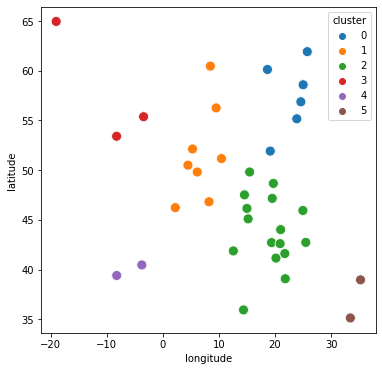

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(data=df_happiness_clustered,
                x="longitude",
                y="latitude",
                hue='cluster',
                s=100)

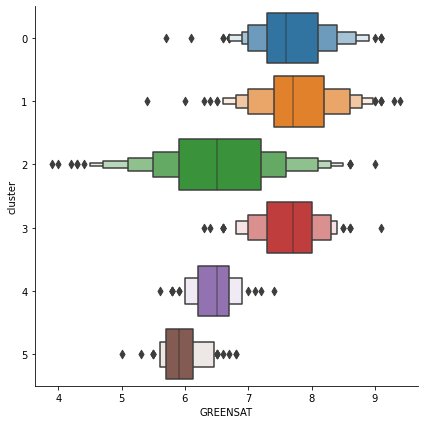

In [ ]:
sns.catplot(data=df_happiness_clustered,
            x="GREENSAT",
            y="cluster",
            kind="boxen", height=6)

## Principal Component Analysis

- Dimensionality reduction
- Anomaly detection
- Noise reduction
- Decorrelation

In [ ]:
from sklearn.preprocessing import StandardScaler

# make sure you standardize your data before applying PCA
scaler = StandardScaler()
columns = ['petal_length', 'petal_width']
df_iris_pca = df_iris.copy()
df_iris_pca[columns] = pd.DataFrame(StandardScaler().fit_transform(df_iris[columns]),
                                    columns=columns,
                                    index=df_iris.index)

from sklearn.decomposition import PCA

pca = PCA()
df_iris_pca[['size', 'shape']] = pd.DataFrame(pca.fit_transform(df_iris_pca[columns]),
                                              index=df_iris.index)

In [ ]:
df_iris_pca.sample(5)

,sepal_length,sepal_width,petal_length,petal_width,class,size,shape
138,6.0,3.0,0.592162,0.790591,Iris-virginica,0.977754,0.140311
55,5.7,2.8,0.421564,0.133226,Iris-versicolor,0.392296,-0.203886
107,7.3,2.9,1.445147,0.790591,Iris-virginica,1.580905,-0.462841
91,6.1,3.0,0.478430,0.264699,Iris-versicolor,0.525472,-0.151131
63,6.1,2.9,0.535296,0.264699,Iris-versicolor,0.565682,-0.191341


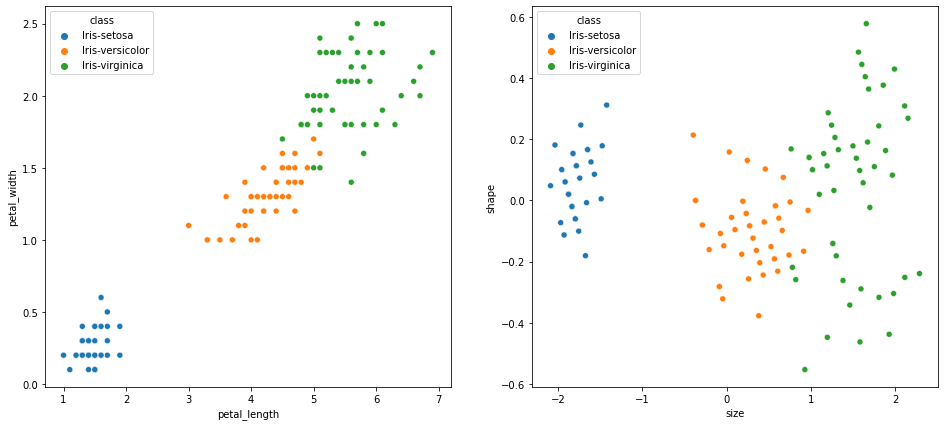

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 7))
sns.scatterplot(data=df_iris,
                x='petal_length',
                y='petal_width',
                hue='class',
                ax=ax[0])

sns.scatterplot(data=df_iris_pca,
                x='size',
                y='shape',
                hue='class',
                ax=ax[1])

In [ ]:
pd.DataFrame(
    pca.components_.T,
    columns=['size', 'shape'],
    index=columns,
)

,size,shape
petal_length,0.707107,-0.707107
petal_width,0.707107,0.707107


In [ ]:
pca.explained_variance_ratio_

array([0.98137855, 0.01862145])

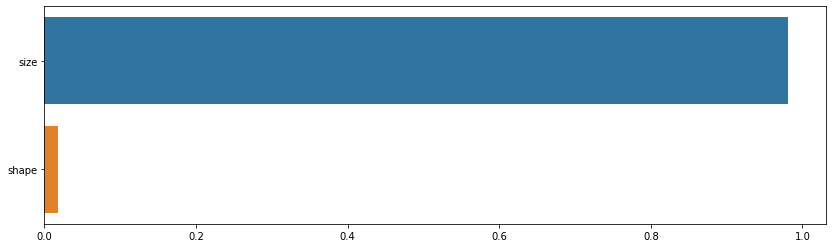

In [ ]:
fig, ax = plt.subplots(figsize=(14, 4))
sns.barplot(y=['size', 'shape'],
            x=pca.explained_variance_ratio_,
            orient='h')

## Target Encoding

In [ ]:
df_happiness_labelencoded = df_happiness.copy()

df_happiness_labelencoded["geo_encoded"] = df_happiness_labelencoded.groupby('geo')['LIFESAT'].transform(np.mean)

df_happiness_labelencoded.sample(5)

,isced11,sex,age,geo,time,ACCSAT,COMSAT,FINSAT,GREENSAT,JOBSAT,LIFESAT,LIVENVSAT,MEANLIFE,RELSAT,TIMESAT,geo_encoded
1505,ED5-8,F,Y25-34,LT,2018,NaN,NaN,6.8,NaN,7.7,7.8,NaN,NaN,8.2,6.1,6.643860
847,ED3_4,F,Y35-49,BG,2013,6.2,5.8,3.7,5.2,5.5,4.9,5.3,6.4,5.7,5.1,5.228070
1178,ED3_4,M,Y25-34,PL,2013,6.9,7.3,5.8,7.5,7.5,7.6,7.5,7.6,8.0,6.3,7.596667
1876,ED5-8,M,Y35-49,EL,2013,6.7,6.2,5.1,5.6,6.6,6.6,5.9,7.1,7.2,6.0,6.458333
2071,ED5_6,F,Y16-24,MT,2013,8.8,NaN,6.9,5.8,NaN,8.0,7.4,7.9,8.5,5.8,7.562857


In [ ]:
%%html
<iframe src="https://contrib.scikit-learn.org/category_encoders/targetencoder.html" width="1100" height="600"></iframe>

# ❓ Exercise

Experiment with some feature engineering techniques on one of the proposed datasets:
- New numerical features
- New categorical features
- Reduction of number of features
- Note: You may use your cleaned dataset from Notebook 2